### Problem Description

One morning Tracey leaves her house and realises that her grass is wet. Is it due to overnight rain or did she forget to turn oﬀ the sprinkler last night? Next she notices that the grass of her neighbour, Jack, is also wet. This *explains away* to some extent the possibility that her sprinkler was left on, and she concludes therefore that it has probably been raining.

### Making a Model

We can model the above situation using probability by following a general modelling approach. First we deﬁne the variables we wish to include in our model. In the above situation, the natural variables are

$R \in \{true, false\}$, corresponds that it has been raining

$S \in \{true, false\}$, corresponds that Tracey has forgotten to turn off sprinkler

$J \in \{true, false\}$, corresponds that Jack's grass is wet

$T \in \{true, false\}$, corresponds that Tracey's Grass is wet 

A model of Tracey’s world then corresponds to a probability distribution on the joint set of the variables of interest p(T, J, R, S) (the order of the variables is irrelevant).

With decompositon, joint probability $P(T, J, R, S)$ can be represent by conditional probabilities and proiors:

$$ P(T, J, R, S) = P(T|R, S) P(J|R) P(R) P(S) $$

The model can be presented as the graph as follows:

<img src="img/wetgrass.png" width="300">

Besides, we assume priors : $P(R=true) = 0.2$, and $P(S=true) = 0.1$; and the remaining probabilities to $P(J = true | R = true) = 1$, $P(J=ture|R=false) = 0.2$ (sometimes Jack’s grass is wet due to unknown eﬀects, other than rain), $P(T = true|R = true, S) = 1$, $P(T = true|R = false, S = true) = 0.9$ (there’s a small chance that even though the sprinkler was left on, it didn’t wet the grass noticeably), $P(T = true|R = false, S = false) = 0$.

### Create Network

In this notebook, we use package **PyMC3** ([official document online](http://docs.pymc.io/)) to show how to use MCMC (Markov Chain Monte Carlo) sampling method to calculate posterior in this case. This package is essentially a MCMC sampler, which can generate samples according to your defination of belief network.

In [1]:
import pymc3

# define model
model = pymc3.Model()

In the context of **PyMC3**, random variables are defined in specified distributions. Such as, normal (Gaussian) and Gamma. It is very intuitive in defining continuous distributions. However, if you want to define a descrete probabilities, it need some work around with help of Bernoulli distribution, Categorical distribution, and function *pymc3.math.switch*.

Bernoulli distribution is defined as

$$ f(x | p) = p^x (1 - p)^{1 - x} $$

Where $x$ is a binary variable, it's a natural way to represent binary random variables. In this way, we can define variable $R$ and $S$ as following

$$
\begin{align}
P(R = true) &= 0.2 \\
P(S = true) &= 0.1
\end{align}
$$

In [2]:
from pymc3 import Bernoulli

with model:
    Rain = Bernoulli('Rain', 0.2)
    Sprinkler = Bernoulli('Sprinkler', 0.1)

For variable $J$ and $T$, it is a little bit complexer. Because, they are defined by conditional probability, which cannot directly expressed as a Bernoulli distribution. Here we use a work around with function *pymc3.math.switch*, which create a *TensorVariable* can do *if-then-else* selection in place.

$$
\begin{align}
    &P(J = true | R = ture) &= 1.0 \\
    &P(J = true | R = false) &= 0.2 \\
\\
    &P(T = true | R = ture, S) &= 1.0 \\
    &P(T = true | R = false, S = true) &= 0.9 \\
    &P(T = true | R = false, S = false) &= 0.0
\end{align}
$$

In [3]:
from pymc3.math import switch

with model:
    Jack = Bernoulli('Jack', switch(Rain, 1, 0.2))
    # use nested switch function to deal with multiple conditions
    Tracey = Bernoulli('Tracey', switch(Rain, 1, switch(Sprinkler, 0.9, 0)))

Now, we have sucessfully define the model. Next step is generating samples, which is handled by function *pymc3.sample*. Sampling process will generate a *trace*, which is actually an array of (variable to value) disctionary. We can utilize function *pymc3.traceplot* to illustrate all obtained samples.

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [Rain, Sprinkler, Jack, Tracey]
100%|██████████| 20500/20500 [00:08<00:00, 2418.34it/s]
The number of effective samples is smaller than 10% for some parameters.


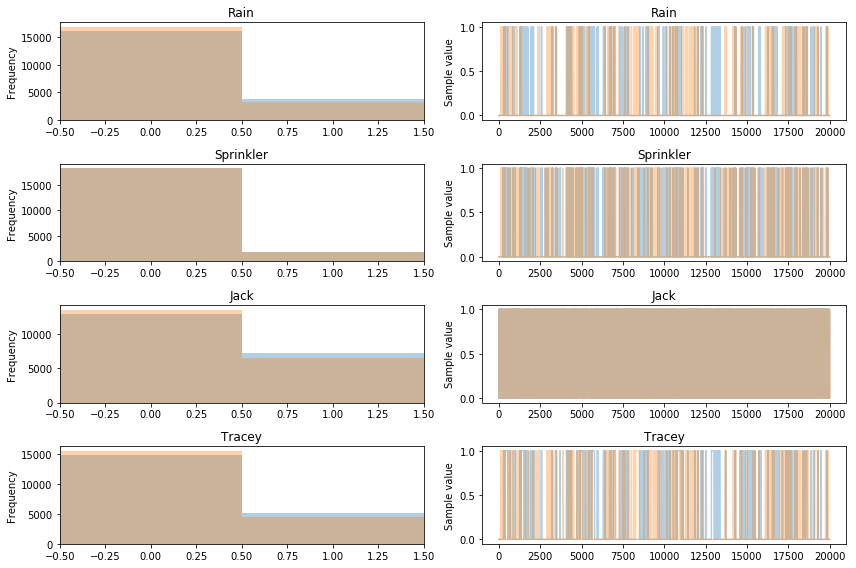

In [4]:
%matplotlib inline

nsamples = 20000

with model:
    trace = pymc3.sample(nsamples, chains=2)
    pymc3.traceplot(trace)

### Posterior Inference

Even though, **PyMC3** provides a lot of methods to show the sampling result. If need numeric result, we have to calculate that by counting the samples.

Here I created a function to provide a simple interface to calculate conditional probability (if you want unconditional probability, just pass a empty dictionary to the third argument).

In [5]:
def calcCondProb(trace, event, cond):
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] == v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] == v]
    # calculate conditional probability
    return len(trace) / nCondSample

Now, let's check two posteriors in the book.

In [6]:
print('P(S = true | T = true) = ', 
      calcCondProb(trace, {'Sprinkler' : 1}, {'Tracey' : 1}))
print('P(S = true | T = true, J = true) =', 
      calcCondProb(trace, {'Sprinkler' : 1}, {'Tracey' : 1, 'Jack' : 1}))

P(S = true | T = true) =  0.3639607493309545
P(S = true | T = true, J = true) = 0.16510538641686182


The result are close to the theoretical posteriors. Increasing number of samples would make the estimation closer to the ground truth. 

### Another Way with Observed Data

As we discussed in class, this sampling method over whole model is inefficient in calculating conditional probability. **PyMC3** provides a method to directly generate samples fulfilling given conditional. This is observed random variables, which is a variable claimed have to match given data. If you assign a single value to it, it act as condition.

With the sample problem, we can generate samples with condition '$T = true$' by a slightly different model.

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [Rain, Sprinkler, Jack]
100%|██████████| 20500/20500 [00:06<00:00, 3334.35it/s]
The number of effective samples is smaller than 25% for some parameters.


P(S = true | T = true) =  0.33585


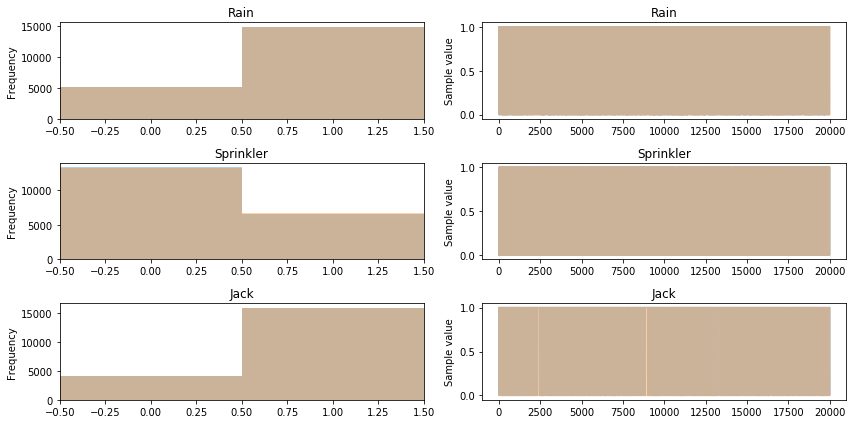

In [8]:
with pymc3.Model() as obsmodel:
    Rain = Bernoulli('Rain', 0.2)
    Sprinkler = Bernoulli('Sprinkler', 0.1)
    Jack = Bernoulli('Jack', switch(Rain, 1, 0.2))
    # specify Tracey as an observed random variable through keyword 'observed'
    Tracey = Bernoulli('Tracey', switch(Rain, 1, switch(Sprinkler, 0.9, 1 / nsamples)), observed=[1.0])
    # sampling with given condition
    trace = pymc3.sample(nsamples)
    # illustrate samples
    pymc3.traceplot(trace)
    # calculate conditional probability 'P(S|T)'
    print('P(S = true | T = true) = ', calcCondProb(trace, {'Sprinkler' : 1}, {}))

There are two things needs to be noticed here:

First, in calculation of posterior, we set argument $cond$ as an empty dictionary, which corresponds to unconditional probability. Because, our samples are already fulfill the condition. And the *trace* doesan't include observed variables anymore. 

Second, in defination of variable $Tracey$, instead of $P(T=true|Rain=false, Sprinkler=false) = 0$, we use a small number ($1 / nsamples$). This is because assigning $0$ here would fail the sampling process (you can try). We don't know why exactly. It maybe a bug.

The observed variable is not only for generating conditional samples, but also can let the model match distribution of given data. We'll show that in *Poisson Process* example.

### Solve the sample problem in pgmpy

If we use **pgmpy** package in **python**, Bayesian networks are described as a directed graph with links between variables.

In [9]:
from pgmpy.models import BayesianModel as bysmodel

# define model with specifying connections between random variables
model = bysmodel([('R', 'J'), ('R', 'T'), ('S', 'T')]);

After, defined structure of Bayesian network. We should assign probabilities to each variable. In **pgmpy**, tabular conditional probabability is used for descrete variables in design.

According to the text book, we have priors : $P(R=true) = 0.2$, and $P(S=true) = 0.1$. We set the remaining probabilities to $P(J = true | R = true) = 1$, $P(J=ture|R=false) = 0.2$ (sometimes Jack’s grass is wet due to unknown eﬀects, other than rain), $P(T = true|R = true, S) = 1$, $P(T = true|R = false, S = true) = 0.9$ (there’s a small chance that even though the sprinkler was left on, it didn’t wet the grass noticeably), $P(T = true|R = false, S = false) = 0$.

In [10]:
from pgmpy.factors.discrete import TabularCPD as tcpd

# define prior with TabularCPD
priorR = tcpd(variable='R', variable_card=2, values=[[0.8, 0.2]])
priorS = tcpd(variable='S', variable_card=2, values=[[0.9, 0.1]])

# define likelihood with TabularCPD
cpdJ = tcpd(variable='J', variable_card=2,
            evidence=['R'], evidence_card=[2],
            values=[[0.8, 0],
                    [0.2, 1]]
           )

cpdT = tcpd(variable='T', variable_card=2,
            evidence=['R', 'S'], evidence_card=[2, 2],
            values=[[1, 0.1, 0, 0],
                    [0, 0.9, 1, 1]]
           )

# add probabilities to model
model.add_cpds(priorR, priorS, cpdJ, cpdT)

# check structure and values consistency with Bayesian Model
model.check_model()

True

### Inference

In **pgmpy**, we can use variable elimination to do Bayesian inference. At first, we need to process the model to prepare for inference.

In [11]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

Now that we’ve built up a model in **python**, we can perform inference. Let’s calculate the probability that the sprinkler was on overnight, given that Tracey’s grass is wet: $P(S = true|T = true)$.

In [12]:
print(infer.query(['S'], evidence={'T' : 1}) ['S'])

╒═════╤══════════╕
│ S   │   phi(S) │
╞═════╪══════════╡
│ S_0 │   0.6618 │
├─────┼──────────┤
│ S_1 │   0.3382 │
╘═════╧══════════╛


Let us now calculate the probability that Tracey’s sprinkler was on overnight, given that her grass is wet and that Jack’s grass is also wet, $P(S = true|T = true, J = true)$.

In [13]:
print(infer.query(['S'], evidence={'T' : 1, 'J' : 1}) ['S'])

╒═════╤══════════╕
│ S   │   phi(S) │
╞═════╪══════════╡
│ S_0 │   0.8396 │
├─────┼──────────┤
│ S_1 │   0.1604 │
╘═════╧══════════╛


The probability that the sprinkler is on, given the extra evidence that Jack’s grass is wet, is lower than the probability that the grass is wet given only that Tracey’s grass is wet. That is, that the grass is wet due to the sprinkler is (partly) explained away by the fact that Jack’s grass is also wet – this increases the chance that the rain has played a role in making Tracey’s grass wet.